In [2]:
%cd ../data/external
!if [ ! -e "CubiCasa5k" ]; then git clone "https://github.com/CubiCasa/CubiCasa5k.git"; fi
%cd CubiCasa5k

!pip install lmdb
!pip install svgpathtools

/home/xfaron/Desktop/Code/Playground/test_construction/data/external
/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k


In [3]:
import os
import sys

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms.v2 import functional as F
from torchvision.ops.boxes import masks_to_boxes, box_area
from floortrans.loaders.house import House
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import random

In [4]:
class FloorplanSVG(Dataset):
    def __init__(self, data_folder, data_file):
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )  # Image normalization
        self.apply_transform = True
        self.image_file_name = "/F1_scaled.png"
        self.org_image_file_name = "/F1_original.png"
        self.svg_file_name = "/model.svg"

        self.data_folder = data_folder
        # Loading txt file
        text_file_path = os.path.join(data_folder, data_file)
        self.folders = np.genfromtxt(text_file_path, dtype="str")

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, index):
        image, target = self.get_data(index)

        if self.apply_transform:
            image = self.transform(image)
        return image, target

    def get_data(self, index):
        fplan = cv2.imread(
            self.data_folder + self.folders[index] + self.image_file_name
        )
        fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
        height, width, _ = fplan.shape

        house = House(
            self.data_folder + self.folders[index] + self.svg_file_name, height, width
        )

        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)

        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(
            dtype=torch.uint8
        )
        boxes = masks_to_boxes(masks)  # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)
        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]

        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        for i in range(len(final_masks)):
            rows, cols = np.where(final_masks[i])
            labels[i] = wall_labels[rows[0], cols[0]]

        target = {}
        target["masks"] = final_masks
        target["boxes"] = final_boxes
        target["labels"] = labels

        return fplan, target

In [5]:
def load_data_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    image, target = dataset[index]
    return image, target


def visualize_data_sample(image, target, mask_index=None, combine_masks=False):
    image_np = image.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    masks = target["masks"].cpu().numpy()
    print(masks.shape)

    if combine_masks:
        combined_mask = np.sum(masks, axis=0)
        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap="gray")
        plt.title("Combined Mask")
        plt.axis("off")
    else:
        if mask_index is None:
            mask_index = 0
        if mask_index < len(masks):
            plt.subplot(1, 2, 2)
            plt.imshow(masks[mask_index], cmap="gray")
            plt.title(f"Mask {mask_index}")
            plt.axis("off")
        else:
            print(
                f"Mask index {mask_index} is out of range. There are {len(masks)} masks."
            )

    plt.show()

In [6]:
room_classes = [
    "Background",
    "Outdoor",
    "Wall",
    "Kitchen",
    "Living Room",
    "Bed Room",
    "Bath",
    "Entry",
    "Railing",
    "Storage",
    "Garage",
    "Undefined",
]
data_folder = "./data/cubicasa5k"

In [7]:
data_file = "train.txt"
dataset = FloorplanSVG(data_folder, data_file)
image, target = load_data_sample(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


(12, 1250, 510)


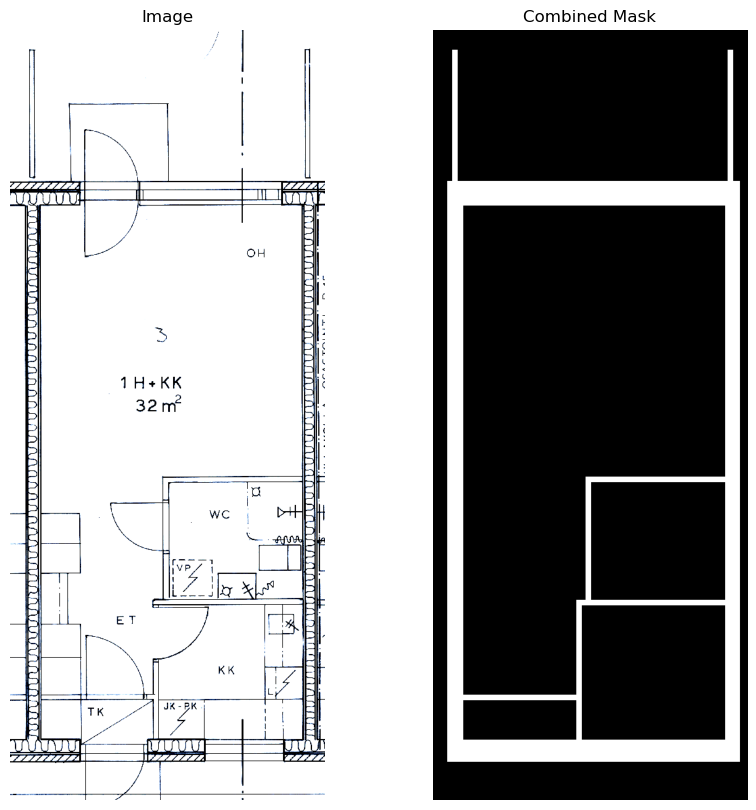

In [8]:
visualize_data_sample(image, target, combine_masks=True)

# Testing out stuff

In [42]:
from typing import List, Tuple
import os

from torch.utils.data import Dataset
from torchvision.ops.boxes import masks_to_boxes, box_area

from tqdm import tqdm
import warnings

# warning_log = []

# def warning_handler(message, category, filename, lineno, file=None, line=None):
#     warning_log.append((filename, str(message)))

# warnings.showwarning = warning_handler

warnings.filterwarnings(
    "ignore", message="libpng warning: iCCP: known incorrect sRGB profile"
)


class WallSegDataset(Dataset):
    def __init__(
        self,
        data_folder: str,
        img_folders: List[str],
        crop_size: int = 512,
        train: bool = True,
    ):
        self.data_folder = data_folder
        self.img_folders = img_folders
        self.crop_size = crop_size
        self.train = train

        self.transform = transforms.ToTensor()

        self.img_file_name = "F1_scaled.png"
        self.svg_file_name = "model.svg"

        self.tiles = []
        for img_path in tqdm(img_folders):
            img_path = os.path.join(self.data_folder, img_path[1:], self.img_file_name)
            img = cv2.imread(img_path)
            h, w, _ = img.shape

            # If the whole image is in one tile
            if h <= self.crop_size and w <= self.crop_size:
                self.tiles.append({"img_path": img_path, "x": 0, "y": 0})
                continue

            # Else, If the tile contains some content (We wont be padding stuff, to create blank tiles in summary)
            for y in range(0, h + 1 - crop_size, crop_size):
                for x in range(0, w + 1 - crop_size, crop_size):
                    self.tiles.append({"img_path": img_path, "x": x, "y": y})

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, index):
        tile = self.tiles[index]
        img_path = tile["img_path"]

        original_img = cv2.imread(img_path)
        height, width, _ = original_img.shape

        # Img preprocessing
        img = self.__pre_process_img(original_img)

        # Getting respective mask
        house = House(
            os.path.join(os.path.dirname(img_path), self.svg_file_name),
            height,
            width,
        )
        mask = self.__get_mask(house)

        # Cutting out the respective tile
        x, y = tile["x"], tile["y"]

        # Pad right if needed
        if x + self.crop_size > width:
            extra_w = x + self.crop_size - width
            img = np.concatenate(
                [img, np.ones((height, extra_w), dtype=img.dtype)], axis=1
            )
            mask = np.concatenate(
                [mask, np.zeros((height, extra_w), dtype=mask.dtype)], axis=1
            )
            width += extra_w

        # Pad bottom if needed
        if y + self.crop_size > height:
            extra_h = y + self.crop_size - height
            img = np.concatenate(
                [img, np.ones((extra_h, width), dtype=img.dtype)], axis=0
            )
            mask = np.concatenate(
                [mask, np.zeros((extra_h, width), dtype=mask.dtype)], axis=0
            )
            height += extra_h

        # Crop (y first, then x)
        img_tile = img[y : y + self.crop_size, x : x + self.crop_size]
        mask_tile = mask[y : y + self.crop_size, x : x + self.crop_size]

        # return original_img, img, mask
        return self.transform(img_tile), self.transform(mask_tile)

    def __pre_process_img(self, original_img, bin_threshold=True):
        # Grayscaling (Color barely matters for wall segmentation)
        if original_img is None:
            raise ValueError("Invalid image")

        img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

        # Gaussian blur
        img = cv2.GaussianBlur(img, (3, 3), 0)

        # Threshold
        if bin_threshold:
            _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Cleanup with morphological opening and closing
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)

        # Edge enhancement
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        sharpened = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
        img = sharpened

        # Normalize
        img = img.astype(np.float32) / 255.0
        return img

    def __get_mask(self, house: House):
        # Took code from earlier
        if house is None:
            raise ValueError("Invalid house")

        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)

        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(
            dtype=torch.uint8
        )
        boxes = masks_to_boxes(masks)  # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)
        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]

        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        for i in range(len(final_masks)):
            rows, cols = np.where(final_masks[i])
            labels[i] = wall_labels[rows[0], cols[0]]

        joint_mask = torch.sum(final_masks, dim=0)
        return joint_mask.numpy().astype(np.float32)

In [43]:
def show_sample(img: torch.Tensor, mask: torch.Tensor):
    original, processed = img, mask
    print("Img Shape: ", original.shape)
    print("Mask Shape: ", processed.shape)

    original = original.numpy()[0]
    processed = processed.numpy()[0]

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].set_title("Pre processed")
    axs[0].imshow(original, cmap="gray")

    axs[1].set_title("Mask")
    axs[1].imshow(processed, cmap="gray")

    plt.show()

In [44]:
from random import shuffle

train_file = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k/train.txt"
val_file = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k/val.txt"
data_folder = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k"

train_folders = []
val_folders = []
with open(train_file) as file, open(val_file) as val_file:
    train_folders = file.read().split("\n")
    val_folders = val_file.read().split("\n")


train_dataset = WallSegDataset(data_folder, train_folders)
val_dataset = WallSegDataset(data_folder, val_folders)

  3%|▎         | 113/4200 [00:03<01:42, 39.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
  8%|▊         | 321/4200 [00:07<01:09, 56.00it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 12%|█▏        | 495/4200 [00:11<01:20, 46.24it/s]libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
libpng warning: iCCP: known incorrect sRGB profile
 19%|█▊        | 782/4200 [00:17<01:12, 47.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
 19%|█▉        | 814/4200 [00:18<01:18, 43.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
 25%|██▍       | 1034/4200 [00:24<01:11, 44.36it/s]libpng warning: iCCP: known incorrec

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
from torchvision.models._utils import IntermediateLayerGetter

torch.hub.set_dir(
    "/home/xfaron/Desktop/Code/Playground/test_construction/utils/torch_cache"
)  # replace with your path


class FPN(nn.Module):
    def __init__(self):
        super(FPN, self).__init__()

        backbone = resnet34(weights=None)
        return_layers = {"layer1": "c1", "layer2": "c2", "layer3": "c3", "layer4": "c4"}

        self.backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)
        out_channels = 64

        # Lateral convs
        self.lateral4 = nn.Conv2d(512, out_channels, 1)
        self.lateral3 = nn.Conv2d(256, out_channels, 1)
        self.lateral2 = nn.Conv2d(128, out_channels, 1)
        self.lateral1 = nn.Conv2d(64, out_channels, 1)

        # Output conv
        self.output_conv = nn.Conv2d(out_channels, 1, 1)

    def forward(self, x: torch.Tensor):
        x = x.repeat(1, 3, 1, 1)

        features = self.backbone(x)
        c1, c2, c3, c4 = features["c1"], features["c2"], features["c3"], features["c4"]

        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, size=c3.shape[2:], mode="nearest")
        p2 = self.lateral2(c2) + F.interpolate(p3, size=c2.shape[2:], mode="nearest")
        p1 = self.lateral1(c1) + F.interpolate(p2, size=c1.shape[2:], mode="nearest")

        out = self.output_conv(F.interpolate(p1, size=x.shape[2:], mode="bilinear"))
        return out


# Kendall style learnable parameters
# L_total = L1 + alpha * L2
# But instead, we go for L_total = L1 / 2*sigma1^2 + L2 / 2*sigma2*2 + log(sigma1) + log(sigma2)
# Here, the sigma's are learnable


class MultiLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_var_bce = nn.Parameter(torch.zeros(1))
        self.log_var_aff = nn.Parameter(torch.zeros(1))

    def forward(self, bce_loss, aff_loss):
        # Uncertainty weighting
        loss = (
            1.0 / (2 * torch.exp(self.log_var_bce))
        ) * bce_loss + self.log_var_bce * 0.5
        loss += (
            1.0 / (2 * torch.exp(self.log_var_aff))
        ) * aff_loss + self.log_var_aff * 0.5
        return loss


def affinity_loss(pred):
    loss = F.binary_cross_entropy_with_logits(
        pred[:, :, 1:, :], pred[:, :, :-1, :]
    ) + F.binary_cross_entropy_with_logits(pred[:, :, :, 1:], pred[:, :, :, :-1])

    return loss

In [51]:
from torch.utils.data import DataLoader
import itertools

training_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)

model = FPN()
criterion = MultiLoss()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), criterion.parameters()), lr=0.001, momentum=0.9
)

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def train_one_epoch(epoch_index):
    running_loss = 0
    last_loss = 0

    i = 0
    for i, data in enumerate(tqdm(training_loader)):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()

        output_mask = model(img)

        aff_loss = affinity_loss(output_mask)
        bce_loss = F.binary_cross_entropy_with_logits(output_mask, mask)
        loss = criterion(bce_loss, aff_loss)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 499:
            last_loss = running_loss / 500
            print(f"Batch : {i + 1}, Loss : {last_loss}")

    return running_loss / i

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

EPOCHS = 5
best_vloss = 1_000_000

exp_name = f"wall_seg_{timestamp}"
exp_folder = "/home/xfaron/Desktop/Code/Playground/test_construction/experiments"

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch + 1}")

    # Training
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    # Evaluation
    vrunning_loss = 0

    model.eval()
    with torch.no_grad():
        for i, vdata in val_loader:
            vimg, vmask = vdata
            vimg, vmask = vimg.to(device), vmask.to(device)

            output_mask = model(vimg)

            aff_loss = affinity_loss(output_mask)
            bce_loss = F.binary_cross_entropy_with_logits(output_mask, vmask)
            vloss = criterion(bce_loss, aff_loss)

            vrunning_loss += vloss

    avg_vloss = (vrunning_loss) / (i + 1)
    print(f"LOSS > Train : {avg_loss}, Val : {avg_vloss}")

    if avg_loss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(exp_folder, exp_name, f"model_{epoch}_{best_vloss}")
        torch.save(model.state_dict(), model_path)

EPOCH: 1


  0%|          | 42/28734 [03:51<78:07:38,  9.80s/it]